In [1]:
%run /data/NNDSP/anal/analysis_notebooks/util.ipynb

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Baracus Performance

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [8]:
analysis_version = "2018_07_10"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Baracus Data

In [12]:
bar_subj = [p.as_posix() for p in bids_bar.glob('sub-*')] # search all subj in baracus directory
df_bar_subj = pd.DataFrame(bar_subj, columns = ['subj_path']) # turn the subjects into df
df_bar_subj = df_bar_subj.assign(participant = lambda df: df.subj_path.str.extract('sub-(\d{2,4})', expand=True)) # add participant number column

In [13]:
df_single_subject = get_single_subject(df_bar_subj, to_int=False) # get cortical thickness, cortical surface area, sub cort volume and stacked anat age predictions

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/data/migineishvilin2/python/e

In [14]:
# Getting Age
df_target = pd.read_csv(brain_age_file, sep=',') # open file with ages
del df_target['nuclear_fam_id']
del df_target['Sex']
del df_target['MRN']

In [15]:
df_bar_subj = df_bar_subj.merge(df_single_subject, on='participant') # merge subje with their age predictions

In [16]:
df_bar_subj = df_bar_subj.assign(MASKID = lambda df: pd.DataFrame([int(x) for x in df.participant]))
df_bar_subj = df_bar_subj.merge(df_target, on='MASKID') # merge age predictions with actual age 

In [17]:
df_bar_subj.head()

,subj_path,participant,aseg,area,thickness,stacked-anatomy,MASKID,age_at_scan
0,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1889,24.4132,127.106,23.7235,25.9323,1889,9.667351
1,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,2011,28.0193,115.121,21.5305,25.6429,2011,18.310746
2,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1948,36.9531,112.181,32.0494,33.4655,1948,14.269678
3,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1198,33.5741,112.062,43.5544,36.189,1198,14.390144
4,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1371,19.7048,117.152,33.1597,26.8287,1371,16.621492


## Mean Absolute Error

In [18]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

# calculate absolute error for each modality
print("Mean Absolute Error (Aseg):", mean_absolute_error(df_bar_subj.iloc[:, 2], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_bar_subj.iloc[:, 3], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_bar_subj.iloc[:, 4], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7]))

Mean Absolute Error (Aseg): 10.779445452614416
Mean Absolute Error (Area): 105.01753576839124
Mean Absolute Error (Thickness): 15.864500891962422
Mean Absolute Error (Stacked Model): 13.787754139640562


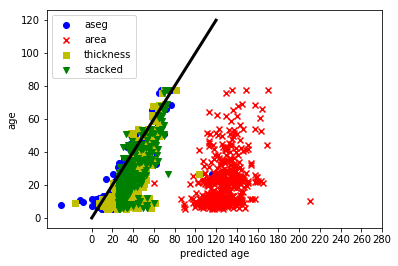

In [19]:
bar_plot(df_bar_subj)

# Train Complex Model on NNDSP Data

In [20]:
# Getting Brain Age
df_target = pd.read_csv(brain_age_file, sep=',')
del df_target['nuclear_fam_id']
del df_target['MRN']

## Setup

In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [22]:
analysis_version = "2018_08_10"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_nndsp') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Subjects

In [23]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

## Extract Freesurfer Data

In [25]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)
features = extract_features(subjects_to_analyze, bids_bar)

## Train Freesurfer Data

### Single Modal: Cortical Thickness

In [26]:
df_data_ct = get_source_data('thickness', features, df_target) # extract thickness info from features
df_data_ct = df_data_ct.sort_values(by='MASKID')

In [27]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_ct.iloc[:, :5124], 
                                                                            df_data_ct.iloc[:,5126], 
                                                                            test_size = 0.5, random_state=None)
# fit model
pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [28]:
# prediction and errors
y_predicted_train_ct = pipe_ct.predict(X_train_ct)
y_predicted_test_ct = pipe_ct.predict(X_test_ct)

In [29]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.09905549821722001
Mean Absolute Error (Test): 5.926619457972174


In [30]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction 
y_predicted_ct_cv = cross_val_predict(pipe_ct, X_train_ct, y_train_ct)

<Figure size 432x288 with 0 Axes>

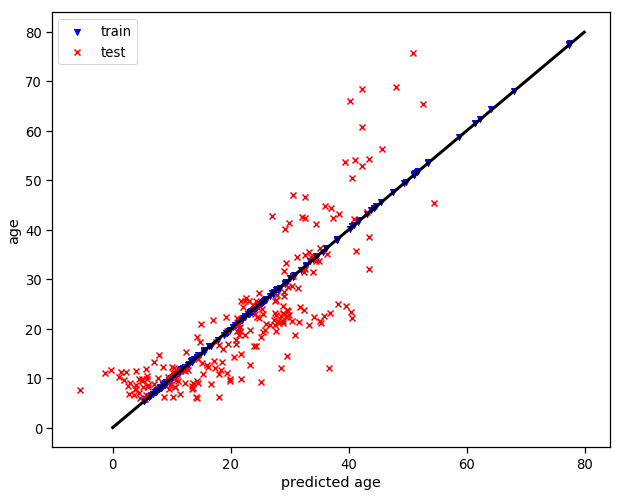

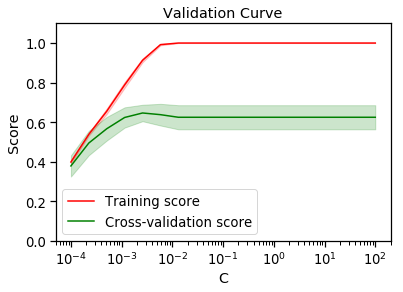

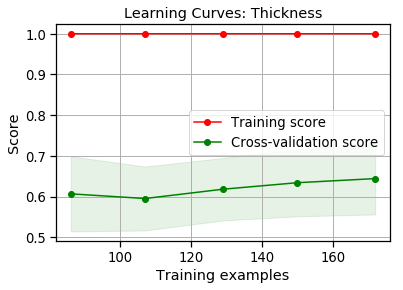

In [31]:
plot_pred(y_predicted_train_ct, y_train_ct, y_predicted_test_ct, y_test_ct, fig_tuple=(10,8), context='notebook') # plot predicted versus age
plot_validation_curve(pipe_ct, X_train_ct, y_train_ct) # plot C versus training and validation score
learning_curve_fct(X_train_ct, y_train_ct, 'Thickness', pipe_ct) # plot number of features training examples versus validation close

### Single Modal: Subcortical Volumes

In [32]:
df_data_sv = get_source_data('aseg', features, df_target)
df_data_sv = df_data_sv.sort_values(by='MASKID')

In [33]:
# Train Test Split
X_train_sv, X_test_sv, y_train_sv, y_test_sv, pipe_sv = train_test_pipeline(df_data_sv.iloc[:, :66], 
                                                                            df_data_sv.iloc[:,68], 
                                                                            test_size = 0.5, 
                                                                            random_state=None, model='yes', 
                                                                            model_train=X_train_ct, 
                                                                            model_test=X_test_ct)

# fit model
pipe_sv.fit(X=X_train_sv, y= y_train_sv.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [34]:
# prediction and errors
y_predicted_train_sv = pipe_sv.predict(X_train_sv)
y_predicted_test_sv = pipe_sv.predict(X_test_sv)

In [35]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_predicted_train_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_predicted_test_sv))

Mean Absolute Error (Train): 4.2989904633067795
Mean Absolute Error (Test): 5.041437239348528


In [36]:
X_train_sv.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
402,4792.7,267.3,15856.2,50953.5,7512.1,3751.5,5320.4,1457.2,945.7,1986.9,...,1.023242e+06,1.009478e+06,1008243.0,1657720.0,0.776464,1.110263,20.0,15.0,35.0,1.493087e+06
131,6763.7,212.8,12795.7,48607.0,7549.6,3932.4,4644.0,1322.7,869.2,1740.0,...,9.633144e+05,9.482484e+05,947187.0,1573550.0,0.745329,1.076153,18.0,24.0,42.0,1.462199e+06
64,4890.3,46.4,14117.1,59049.8,7904.3,3663.2,5427.2,1571.0,979.2,2598.5,...,9.432939e+05,9.316989e+05,930045.0,1507115.0,0.768385,1.059592,31.0,28.0,59.0,1.422354e+06
243,4678.1,311.5,12963.2,52100.3,7476.6,3716.2,5045.8,1261.9,663.4,1880.5,...,9.272107e+05,9.157337e+05,914566.0,1540075.0,0.727298,1.057756,11.0,8.0,19.0,1.455983e+06
306,5056.8,203.1,18764.9,61203.2,9046.7,5006.3,7294.1,1994.2,831.1,1510.3,...,1.147108e+06,1.135668e+06,1134218.0,1858590.0,0.738665,1.046641,26.0,23.0,49.0,1.775766e+06


In [37]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_sv_cv = cross_val_predict(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

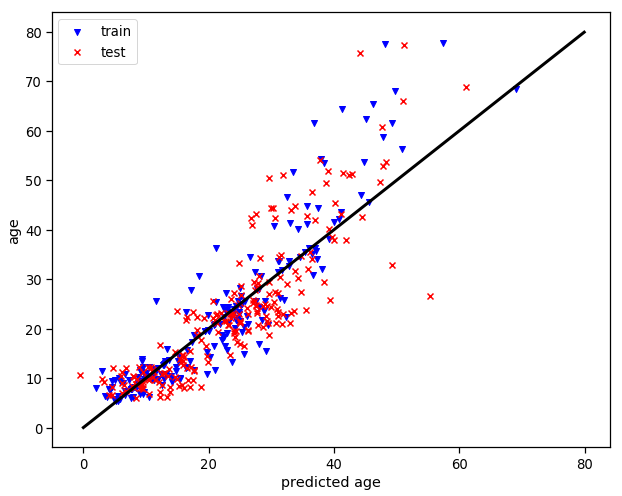

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


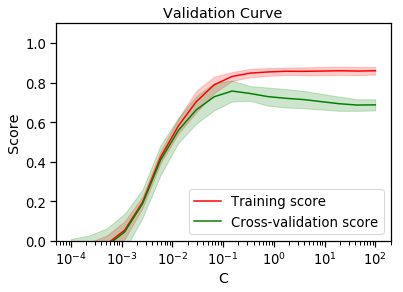

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


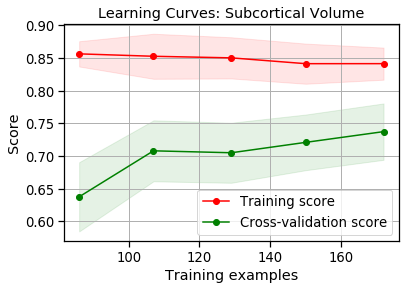

In [29]:
plot_pred(y_predicted_train_sv, y_train_sv, y_predicted_test_sv, y_test_sv, context='notebook') # plot predicted age vs age
plot_validation_curve(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel()) # plot C versis training and validation scroe
learning_curve_fct(X_train_sv, y_train_sv.as_matrix().ravel(), 'Subcortical Volume', pipe_sv) # plot number of training examples vs training and validation score

### Single Modal: Cortical Surface Area

In [38]:
df_data_ca = get_source_data('area', features, df_target)
df_data_ca = df_data_ca.sort_values(by='MASKID')

In [39]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_ca.iloc[:, :5124], df_data_ca.iloc[:,5126], test_size = 0.5, random_state=None, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_ca.fit(X=X_train_ca, y=y_train_ca.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [40]:
# prediction and errors
y_predicted_train_ca = pipe_ca.predict(X_train_ca)
y_predicted_test_ca = pipe_ca.predict(X_test_ca)

In [41]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.09919997988379971
Mean Absolute Error (Test): 7.065801348573705


In [42]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_ca_cv = cross_val_predict(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_ca_cv))

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error (Train): 8.423712877504256


<Figure size 432x288 with 0 Axes>

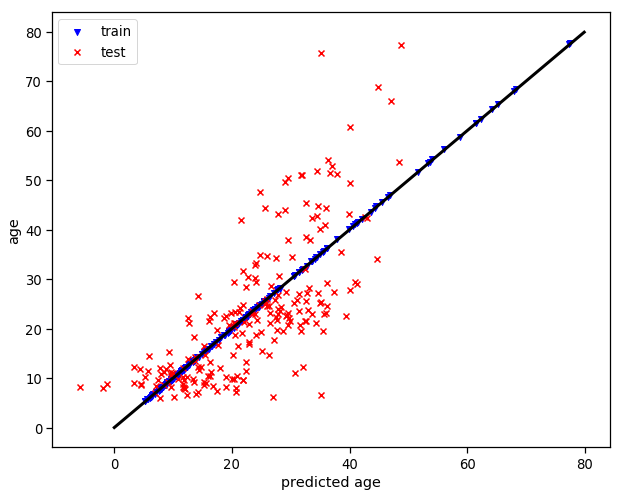

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


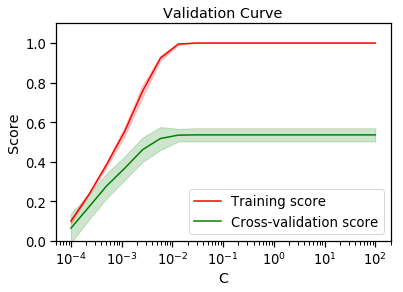

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


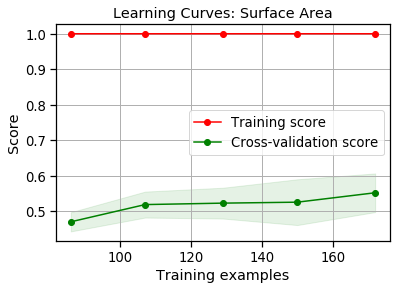

In [35]:
plot_pred(y_predicted_train_ca, y_train_ca, y_predicted_test_ca, y_test_ca)
plot_validation_curve(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
learning_curve_fct(X_train_ca, y_train_ca.as_matrix().ravel(), 'Surface Area', pipe_ca)

### Stacked Anatomy

In [43]:
# stack predicted values
# get stacked age predictions (test and train) for ct
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct, first=True)
# get stacked age prediction (test and train) for ca
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
# get stacked age prediction (test and train) for sv
df_y_sv = get_stacked_ages(y_train_sv, y_predicted_train_sv, y_predicted_sv_cv, y_test_sv, y_predicted_test_sv)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [44]:
# stacking function inputes
target = 'age'

source_dict = {'aseg': df_y_sv, 'ct': df_y_ct,'ca': df_y_ca}

source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

#### Training Random Forest Function

In [45]:
scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, target, show=False)

Fitting stacking model
best max_depth: 3


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

In [46]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan, dd_train.pred_age_train))
print("Mean Absolute Error (Test):", mean_absolute_error(dd_test.age_at_scan, dd_test.pred_age_test))
scores_test

Mean Absolute Error (Train): 3.6109587306280306
Mean Absolute Error (Test): 4.221679749826013


,r2,rpear,rpear2,mae,medae
aseg,0.761731,0.874236,0.764288,5.041437,4.133491
ct,0.679988,0.827526,0.684800,5.926619,4.632010
ca,0.566947,0.766349,0.587290,7.065801,6.082872
mean_pred,0.780237,0.893323,0.798025,4.805740,3.734121
pred_age_test,0.820469,0.908325,0.825054,4.221680,3.106407


In [47]:
y_predicted_stack_cv = cross_val_predict(pipe_stack, dd_train.iloc[:,:3], dd_train.age_at_scan.values)
print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan.values, y_predicted_stack_cv))

Mean Absolute Error (Train): 5.173333593524514


# Train Basic Anatomical Features

## Setup

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [50]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Subjects

In [51]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

In [52]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)

## Extract Anatomical Feature Data

In [53]:
df_atf = pd.DataFrame([])
df_atf = df_atf.assign(MASKID = [int(x[4:]) for x in subjects_to_analyze])
df_atf = df_atf.merge(df_target, on = 'MASKID')

In [54]:
white_matter, grey_matter, csf, intra_cran_vol = get_anat_features(subjects_to_analyze, bids_bar)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [55]:
# calculate white matter fraction
white_matter = calc_fraction(white_matter, intra_cran_vol)
# calculate grey matter fraction
grey_matter = calc_fraction(grey_matter, intra_cran_vol)
# calculate csf fraction
csf = calc_fraction(csf, intra_cran_vol)

In [56]:
df_atf = df_atf.assign(Intra_Cran_Vol = intra_cran_vol)
df_atf = df_atf.assign(WM_Frac = white_matter)
df_atf = df_atf.assign(GM_Frac = grey_matter)
df_atf = df_atf.assign(CSF_Frac = csf)
df_atf = df_atf.sort_values(by='MASKID')

## Train Basic Anatomical Feature Data

In [57]:
X_train_atf, X_test_atf, y_train_atf, y_test_atf, pipe_atf =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.iloc[:, 2], 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
pipe_atf.fit(X=X_train_atf, y=y_train_atf.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [58]:
# prediction and errors
y_predicted_train_atf = pipe_atf.predict(X_train_atf)
y_predicted_test_atf = pipe_atf.predict(X_test_atf)

In [59]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_atf, y_predicted_train_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_atf, y_predicted_test_atf))

Mean Absolute Error (Train): 7.082579592313243
Mean Absolute Error (Test): 6.372233845625203


In [60]:
from sklearn.cross_validation import cross_val_predict

y_predicted_atf_cv = cross_val_predict(pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())
print("Mean Absolute Error (CV):", mean_absolute_error(y_train_atf, y_predicted_atf_cv))

Mean Absolute Error (CV): 7.568962693393467


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Test HCP Data

## Setup

In [61]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [62]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_nndsp') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# HCP Directory
hcp_dir = Path('/data/HCP/HCP_900/s3/hcp')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP Outfir of Prepared Freesurfer Files
hcp_bar_dir = project_dir.joinpath('derivatives/bar_hcp/')

# HCP Freesurfer Data
hcp_fs_dir = project_dir.joinpath('derivatives/fs_hcp/')

print(hcp_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derivatives/fs_hcp


## Extract HCP Data

### Extract Subject Ages

In [63]:
import matplotlib.pyplot as plt
df_hcp_age = pd.read_csv(project_dir.joinpath('nino/HCP_ages.csv'))
df_hcp_age = pd.DataFrame(df_hcp_age[['Subject','Age_in_Yrs']])

### Extract HCP Data Simple Model

In [64]:
import os
from glob import glob

# get the subjects in the freesurfer directory
hcp_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(hcp_bar_dir, "sub-*")))]

In [66]:
hcp_subjects_to_analyze = subject_to_anal(hcp_subj_dirs, hcp_bar_dir)

In [67]:
# get age and subject number
df_hcp_atf = pd.DataFrame([])
df_hcp_atf = df_hcp_atf.assign(Subject = [int(x[4:]) for x in hcp_subjects_to_analyze])
df_hcp_atf = df_hcp_atf.merge(df_hcp_age, on = 'Subject')

In [68]:
white_matter_hcp, grey_matter_hcp, csf_hcp, intra_cran_vol_hcp = get_anat_features(hcp_subjects_to_analyze, hcp_bar_dir)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [69]:
# calculate white matter fraction
white_matter_hcp = calc_fraction(white_matter_hcp, intra_cran_vol_hcp)

# calculate grey matter fraction
grey_matter_hcp = calc_fraction(grey_matter_hcp, intra_cran_vol_hcp)

# calculate csf fraction
csf_hcp = calc_fraction(csf_hcp, intra_cran_vol_hcp)

In [70]:
df_hcp_atf = df_hcp_atf.assign(Intra_Cran_Vol = intra_cran_vol_hcp)
df_hcp_atf = df_hcp_atf.assign(WM_Frac = white_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(GM_Frac = grey_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(CSF_Frac = csf_hcp)

### Extract HCP Data Complex Model

In [71]:
hcp_features = extract_features(hcp_subjects_to_analyze, hcp_bar_dir)

## Test HCP Data

In [72]:
bar_subj_hcp = [p.as_posix() for p in hcp_bar_dir.glob('sub-*')] # search all subj in baracus directory
df_bar_subj_hcp = pd.DataFrame(bar_subj_hcp) # turn the subjects into df
df_bar_subj_hcp.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_hcp = df_bar_subj_hcp.assign(Subject = lambda df: df.subj_path.str.extract('sub-(\d{2,6})', expand=True))# add participant number column

In [73]:
df_single_subject_hcp = get_single_subject(df_bar_subj_hcp)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [74]:
df_single_subject_hcp = df_single_subject_hcp.dropna()
df_single_subject_hcp.Subject = [int(x) for x in df_single_subject_hcp.participant]

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [75]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_hcp = df_single_subject_hcp.rename(columns={'participant': 'Subject'})
df_single_subject_hcp = df_single_subject_hcp.sort_values(by='Subject')

In [76]:
df_single_subject_hcp.Subject = [int(s) for s in df_single_subject_hcp.Subject]

In [77]:
df_single_subject_hcp = pd.merge(df_single_subject_hcp, df_hcp_age, on = 'Subject')

In [78]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_hcp.iloc[:, 1], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_hcp.iloc[:, 2], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_hcp.iloc[:, 3], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5]))

Mean Absolute Error (Aseg): 8.606845075082761
Mean Absolute Error (Area): 108.86989762334686
Mean Absolute Error (Thickness): 13.344539819164329
Mean Absolute Error (Stacked Model): 7.925877847825217


### Test Against Complex Model

In [79]:
df_data_hcp_ct = get_source_data('thickness', hcp_features, df_hcp_age, on='Subject')

In [80]:
y_predicted_hcp_ct = pipe_ct.predict(df_data_hcp_ct.iloc[:,:5124])

In [81]:
df_data_hcp_sv = get_source_data('aseg', hcp_features, df_hcp_age, on='Subject')

In [82]:
y_predicted_hcp_sv = pipe_sv.predict(df_data_hcp_sv.iloc[:,:66])

In [83]:
df_data_hcp_ca = get_source_data('area', hcp_features, df_hcp_age, on='Subject')

In [84]:
y_predicted_hcp_ca = pipe_ca.predict(df_data_hcp_ca.iloc[:,:5124])

In [85]:
#### Stacked Anatomy
df_stack_hcp = pd.DataFrame([])
df_stack_hcp['aseg'] = y_predicted_hcp_sv
df_stack_hcp['ct'] = y_predicted_hcp_ct
df_stack_hcp['ca'] = y_predicted_hcp_ca
df_stack_hcp['Subject'] = df_data_hcp_ct.Subject.values

In [86]:
y_predicted_stack_hcp = pipe_stack.predict(df_stack_hcp.iloc[:,:3])

In [87]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp))

Mean Absolute Error (HCP): 5.186404207305853


### Test Against Simple Model

In [88]:
# test HCP Inputs with Simple Model
y_predicted_hcp_atf = pipe_atf.predict(df_hcp_atf.iloc[:, 2:])

In [89]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf))

Mean Absolute Error (HCP): 10.06016874205269


# Test NKI Data

## Setup

In [91]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_nndsp') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# NKI Directory
nki_dir = Path('/data/NNDSP/anal/NKI')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# NKI Behavioral Data File
nki_bh_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# NKI baracus
nki_bar_dir = project_dir.joinpath('derivatives/bar_nki/')

# NKI Freesurfer Data
nki_fs_dir = project_dir.joinpath('derivatives/fs_nki')

print(nki_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derivatives/fs_nki


In [92]:
df_nki_ages = pd.read_csv(project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv'), sep='\t')

## Extract NKI Data

In [93]:
import os
from glob import glob

# get the subjects in the freesurfer directory
nki_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(nki_bar_dir, "sub-*")))]

In [95]:
nki_subjects_to_analyze = subject_to_anal(nki_subj_dirs, nki_bar_dir)

In [96]:
# get age and subject number
df_nki_atf = pd.DataFrame([])
df_nki_atf = df_nki_atf.assign(participant_name = [x for x in nki_subjects_to_analyze])
df_nki_atf = df_nki_atf.assign(participant_id = [x[4:13] for x in df_nki_atf.participant_name.values])
df_nki_atf = df_nki_atf.drop_duplicates(subset='participant_id', keep='first')
df_nki_atf = df_nki_atf.merge(df_nki_ages, on = 'participant_id')

In [97]:
white_matter_nki, grey_matter_nki, csf_nki, intra_cran_vol_nki = get_anat_features(df_nki_atf.participant_name.values, nki_bar_dir)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [98]:
# calculate white matter fraction
white_matter_nki = calc_fraction(white_matter_nki, intra_cran_vol_nki)

# calculate grey matter fraction
grey_matter_nki = calc_fraction(grey_matter_nki, intra_cran_vol_nki)

# calculate csf fraction
csf_nki = calc_fraction(csf_nki, intra_cran_vol_nki)

In [99]:
df_nki_atf = df_nki_atf.assign(Intra_Cran_Vol = intra_cran_vol_nki)
df_nki_atf = df_nki_atf.assign(WM_Frac = white_matter_nki)
df_nki_atf = df_nki_atf.assign(GM_Frac = grey_matter_nki)
df_nki_atf = df_nki_atf.assign(CSF_Frac = csf_nki)

### Extract NKI Data Complex Model

In [100]:
nki_features = extract_features(df_nki_atf.participant_name.values, nki_bar_dir)

### Test against LeiCa_LIFE Model

In [101]:
df_bar_subj_nki = pd.DataFrame([p.as_posix() for p in nki_bar_dir.glob('sub-*')]) # search all subj in baracus directory and turn the subjects into df
df_bar_subj_nki.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_nki = df_bar_subj_nki.assign(participant_id = lambda df: df.subj_path.str.extract('sub-(A\d{2,8})', expand=True))# add participant number column

In [102]:
df_bar_subj_nki = df_bar_subj_nki.sort_values(by='participant_id')
df_bar_subj_nki = df_bar_subj_nki.drop_duplicates(subset='participant_id', keep='first')

In [103]:
df_bar_subj_nki = df_bar_subj_nki.merge(df_nki_ages, on='participant_id')

In [104]:
df_single_subject_nki = get_single_subject(df_bar_subj_nki, to_int=False)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/data/migineishvilin2/python/e

In [105]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_nki = df_single_subject_nki.rename(columns={'participant': 'participant_id'})
df_single_subject_nki = df_single_subject_nki.sort_values(by='participant_id')
df_single_subject_nki = df_single_subject_nki.merge(df_nki_ages, on = 'participant_id')

In [106]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_nki.iloc[:, 1], df_single_subject_nki.age))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_nki.iloc[:, 2], df_single_subject_nki.age))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_nki.iloc[:, 3], df_single_subject_nki.age))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_nki.iloc[:, 4], df_single_subject_nki.age))

Mean Absolute Error (Aseg): 10.02686685751305
Mean Absolute Error (Area): 100.53087712779117
Mean Absolute Error (Thickness): 9.834342436370935
Mean Absolute Error (Stacked Model): 9.452750232619469


### Test Against Complex Model

In [107]:
df_data_nki_ct = get_source_data('thickness', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [108]:
y_predicted_nki_ct = pipe_ct.predict(df_data_nki_ct.iloc[:,:5124])

In [109]:
df_data_nki_sv = get_source_data('aseg', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [110]:
y_predicted_nki_sv = pipe_sv.predict(df_data_nki_sv.iloc[:,:66])

In [111]:
df_data_nki_ca = get_source_data('area', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [112]:
y_predicted_nki_ca = pipe_ca.predict(df_data_nki_ca.iloc[:,:5124])

In [113]:
#### Stacked Anatomy
df_stack_nki = pd.DataFrame([])
df_stack_nki['aseg'] = y_predicted_nki_sv
df_stack_nki['ct'] = y_predicted_nki_ct
df_stack_nki['ca'] = y_predicted_nki_ca
df_stack_nki['participant_id'] = df_data_nki_ct.participant_id.values

In [114]:
y_predicted_stack_nki = pipe_stack.predict(df_stack_nki.iloc[:,:3])

In [115]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_data_nki_ca.age, y_predicted_stack_nki))

Mean Absolute Error (NKI): 8.326411485252034


### Test Against Simple Model

In [116]:
if 'participant_name' in df_nki_atf.columns:
    del df_nki_atf['participant_name']

In [117]:
# test HCP Inputs with Simple Model
y_predicted_nki_atf = pipe_atf.predict(df_nki_atf.iloc[:, 4:])

In [118]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf))

Mean Absolute Error (NKI): 13.723921016214385


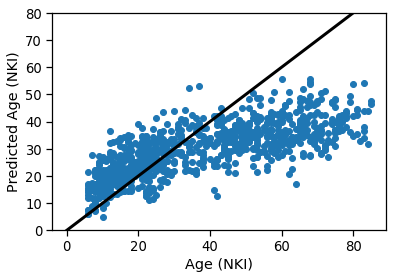

In [119]:
import matplotlib.pyplot as plt

plt.scatter(df_nki_atf.age, y_predicted_nki_atf)
plt.plot(numpy.arange(0,80,0.1), numpy.arange(0,80,0.1), c='black', linewidth = 3)
plt.xlabel("Age (NKI)")
plt.ylabel("Predicted Age (NKI)")
plt.ylim(0, 80)
plt.show()

# Statistical Tests

In [120]:
%run /data/NNDSP/anal/analysis_notebooks/stat_tests.ipynb

## Hypothesis #1

If we train a previously presented machine learning model predicting age from a large number of derived anatomical features on a new data set, it will perform better than chance at predicting age outside of the training data.

### Chance on Shaw Data

In [121]:
# get all the subject ages from Shaw Data
subject_ages = [x for x in df_data_ca.age_at_scan]
df_subject_ages = pd.DataFrame(subject_ages)
# df of random age predictions
df_random_ages = pd.DataFrame([])
df_random_ages = df_random_ages.assign(MASKID = df_data_ca.MASKID)

In [122]:
df_random_ages = random_its(1000, df_random_ages, subject_ages)

In [123]:
arr_mae = get_arr_mae(df_random_ages, df_subject_ages)

In [218]:
def plot_rand_histOne(mae, lines=None, xlim_min=0, x_max = None, title="", set_context='notebook', fig_tuple=(5,5), legend=True):
    
#     if not x_max:
#         x_max = max(mae)
    
    # plot MAE Distribution
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.mlab as mlab
    import seaborn as sns
    
    sns.set_context(set_context, font_scale=1.3)
    sns.set_style('whitegrid')
    sns.set_palette("Set1", 8, .75)
    # plotting the Histogram
    plt.figure(1)
    plt.figure(figsize=fig_tuple)
    plt.hist(mae, label='Random MAE Distribution', density=True)
    plt.xlim(xlim_min, x_max)
    plt.xlabel("Mean Absolute Error (years)")
    plt.ylabel("Density")
    #plt.ylabel("Percentage of mean absolute error in each group")

    colors = ['darkblue', 'slateblue', 'rebeccapurple', 'darkviolet', 'violet', 'fuchsia', 'deeppink', 'crimson']
    color_counter = 0
    
    if lines:
        for key, x in lines.items():
            # plot MAE complex
            plt.axvline(x, ymax=1, label=key, color=colors[color_counter])
            color_counter+=1
    
    plt.title(title)
    
    if legend:
        plt.legend(loc='upper left')
    
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/chance_' + title.split(' ')[0] +'.png', dpi=300)        
    plt.show()

In [147]:
scores_test.get_value(index='pred_age_test', col='mae')

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


4.221679749826013

In [148]:
mean_absolute_error(y_train_atf, y_predicted_train_atf)

7.082579592313243

In [164]:
print(min(arr_mae), max(arr_mae))

13.832181180846867 17.512875362515082


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

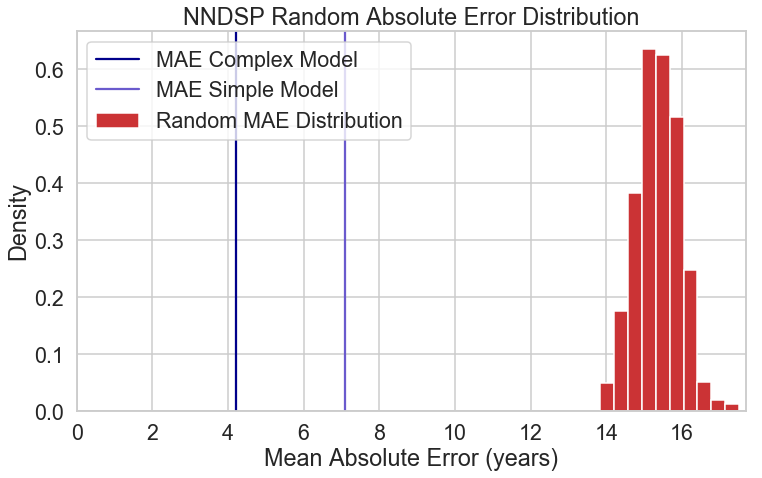

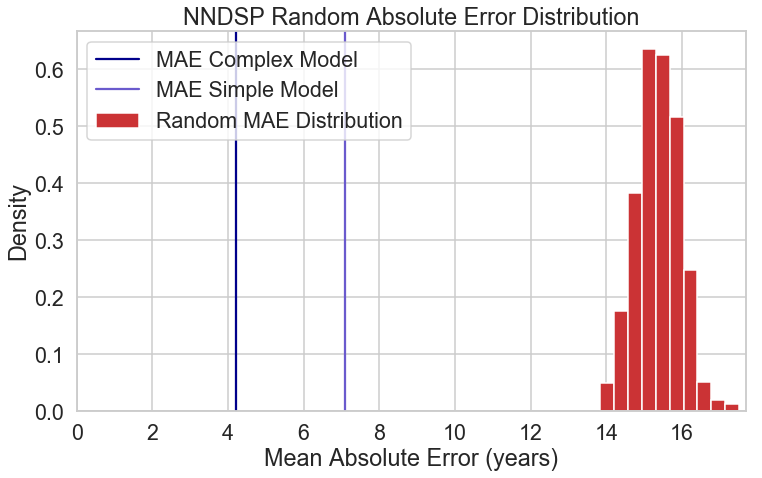

In [219]:
lines = {
    'MAE Complex Model' : scores_test.get_value(index='pred_age_test', col='mae'),
    'MAE Simple Model' : mean_absolute_error(y_train_atf, y_predicted_train_atf),
    #'MAE Simple Stacked Model' : mean_absolute_error(y_test_atf, y_predicted_test_ss),
}
plot_rand_histOne(arr_mae, lines, title='NNDSP Random Absolute Error Distribution', set_context='talk',
               fig_tuple=(12, 7))

In [134]:
print("Percentile of MAE Complex Model", percentile(arr_mae, scores_test.get_value(index='pred_age_test', col='mae')))

Percentile of MAE Complex Model 0.0


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


In [135]:
print("Percentile of MAE Simple Model", percentile(arr_mae, mean_absolute_error(y_train_atf, y_predicted_train_atf)))

Percentile of MAE Simple Model 0.0


In [136]:
print("Percentile of MAE Baracus", percentile(arr_mae, mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7])))

Percentile of MAE Baracus 0.0


### Chance on HCP Data

In [137]:
# get all the subject ages
subject_hcp_ages = [x for x in df_hcp_age.Age_in_Yrs]
df_hcp_subject_ages = pd.DataFrame(subject_hcp_ages)
# df of random age predictions
df_hcp_random_ages = pd.DataFrame([])
df_hcp_random_ages = df_hcp_random_ages.assign(Subject = df_hcp_age.Subject)

In [138]:
df_hcp_random_ages = random_its(1000, df_hcp_random_ages, subject_hcp_ages)

In [139]:
arr_mae_hcp = get_arr_mae(df_hcp_random_ages, df_hcp_subject_ages)

In [140]:
print(mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp))
print(mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf))

5.186404207305853
10.06016874205269


In [165]:
print(min(arr_mae_hcp), max(arr_mae_hcp))

3.92620232172471 4.540630182421228
3.92620232172471 4.540630182421228


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

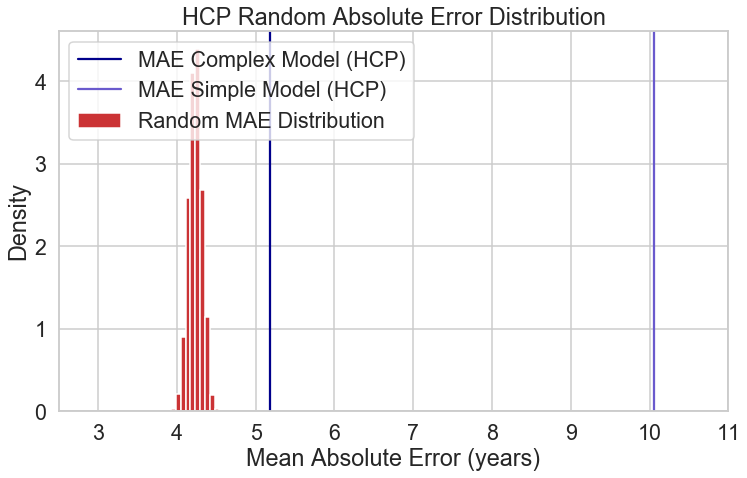

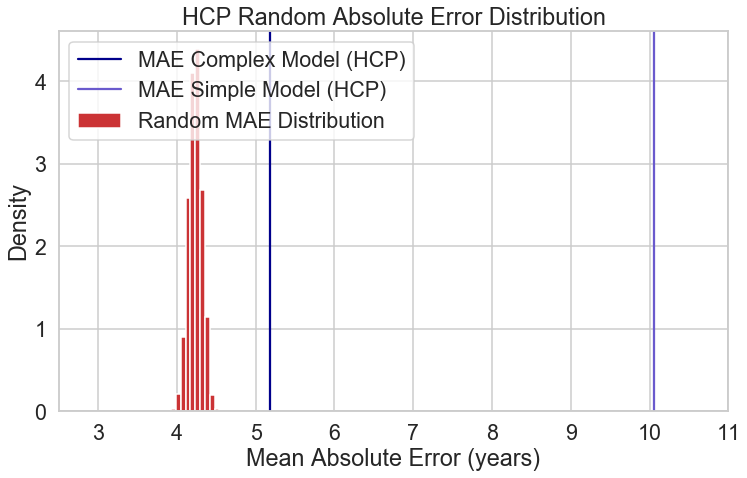

In [220]:
hcp_lines = {
    'MAE Complex Model (HCP)' : mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp),
    'MAE Simple Model (HCP)' : mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)
}
plot_rand_histOne(arr_mae_hcp, hcp_lines, xlim_min = 2.5, x_max = 11, 
                  title='HCP Random Absolute Error Distribution',
              set_context='talk', fig_tuple=(12, 7), legend=True)

In [151]:
print("Percentile of MAE Complex Model (HCP)", percentile(arr_mae_hcp, 
                                                    mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp)))

Percentile of MAE Complex Model (HCP) 100.0


In [152]:
print("Percentile of MAE Simple Model (HCP)", percentile(arr_mae_hcp, 
                                                  mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)))

Percentile of MAE Simple Model (HCP) 100.0


In [153]:
print("Percentile of MAE Baracus (HCP)", percentile(arr_mae_hcp,
                                                    mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5])))

Percentile of MAE Baracus (HCP) 100.0


### Chance on NKI Data

In [154]:
# get all the subject ages
subject_nki_ages = [x for x in df_nki_atf.age]
df_nki_subject_ages = pd.DataFrame(subject_nki_ages)
# df of random age predictions
df_nki_random_ages = pd.DataFrame([])
df_nki_random_ages = df_nki_random_ages.assign(participant_id = df_nki_atf.participant_id)

In [155]:
df_nki_random_ages = random_its(1000, df_nki_random_ages, subject_nki_ages)

In [157]:
arr_mae_nki = get_arr_mae(df_nki_random_ages, df_nki_subject_ages)

In [166]:
print(mean_absolute_error(df_data_nki_ca.iloc[:,5125], y_predicted_stack_nki))
print(mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf))

8.326411485252034
13.723921016214385
8.326411485252034
13.723921016214385
8.326411485252034
13.723921016214385


In [170]:
print(min(arr_mae_nki), max(arr_mae_nki))

22.95608108108108 26.286036036036037
22.95608108108108 26.286036036036037
22.95608108108108 26.286036036036037
22.95608108108108 26.286036036036037


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

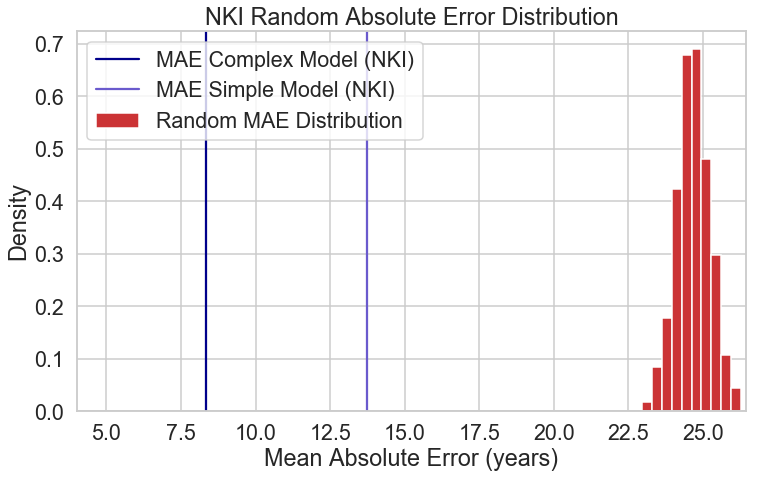

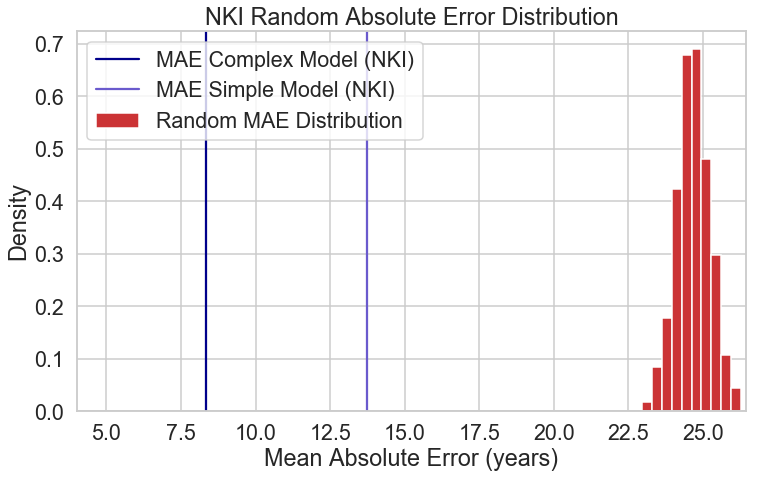

In [221]:
nki_lines = {
    'MAE Complex Model (NKI)' : mean_absolute_error(df_data_nki_ca.iloc[:,5125], y_predicted_stack_nki),
    'MAE Simple Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf),
    #'MAE Simple Stacked Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_ss),
}
plot_rand_histOne(arr_mae_nki, nki_lines, xlim_min =4, title='NKI Random Absolute Error Distribution',
              set_context='talk', fig_tuple=(12, 7))

In [159]:
print("Percentile of MAE Complex Model (NKI)", percentile(arr_mae_nki, 
                                                    mean_absolute_error(df_data_nki_ca.iloc[:,5125], 
                                                                        y_predicted_stack_nki)))

Percentile of MAE Complex Model (NKI) 0.0


In [160]:
print("Percentile of MAE Simple Model (NKI)", percentile(arr_mae_nki, 
                                                  mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf)))

Percentile of MAE Simple Model (NKI) 0.0


In [162]:
print("Percentile of MAE Baracus (NKI)", percentile(arr_mae_nki,
                                                    mean_absolute_error(df_single_subject_nki.age, df_single_subject_nki.iloc[:, 5])))

Percentile of MAE Baracus (NKI) 0.0


## Hypothesis #2 

The model trained with many derived features will have better out of sample performance than a model trained with fewer, simpler features.

### Complex Model vs. Simple Model

In [181]:
temp_tr = y_train_atf.assign(y_pred = y_predicted_train_atf).sort_index()

statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_tr.y_pred.values, temp_tr.age_at_scan.values), 
                                      np.subtract(dd_train.pred_age_train, dd_train.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  10442.0 
 Pvalue:  0.20090413025631815 
 Correlation:  0.44969853574504737


<Figure size 432x288 with 0 Axes>

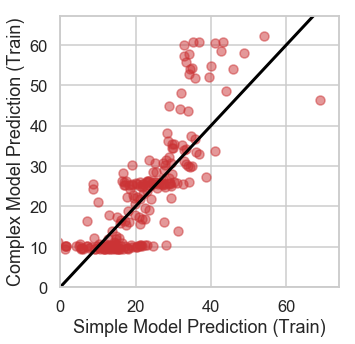

In [182]:
plot_simple_v_complex(temp_tr.y_pred.values, dd_train.pred_age_train, "(Train)")

In [185]:
temp_ts = y_test_atf.assign(y_pred = y_predicted_test_atf).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  10175.0 
 Pvalue:  0.09336301510680446 
 Correlation:  0.4341611196449906


<Figure size 432x288 with 0 Axes>

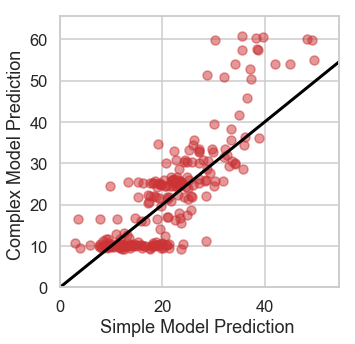

In [186]:
plot_simple_v_complex(temp_ts.y_pred, dd_test.pred_age_test, "", fig_tuple=(5, 5), fig_title='simple_graph.png')

In [222]:
def plot_ae_histOne(plot_list, title="", set_context='notebook', fig_tuple=(5,5), file_title=''):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_context(set_context, font_scale=1.3)
    sns.set_style('whitegrid')
    sns.set_palette("Set1", 8, .75)
    
    fig,ax =plt.subplots(1, figsize=fig_tuple)
    
    for key, x in plot_list.items():
        sns.distplot(x, ax = ax, label = key)
    
    plt.legend(loc="best")
    plt.xlabel("Error (years)")
    plt.ylabel("Density")
    #plt.ylabel("Fraction")
    plt.title(title)
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/'+file_title, dpi=300)
    plt.show()

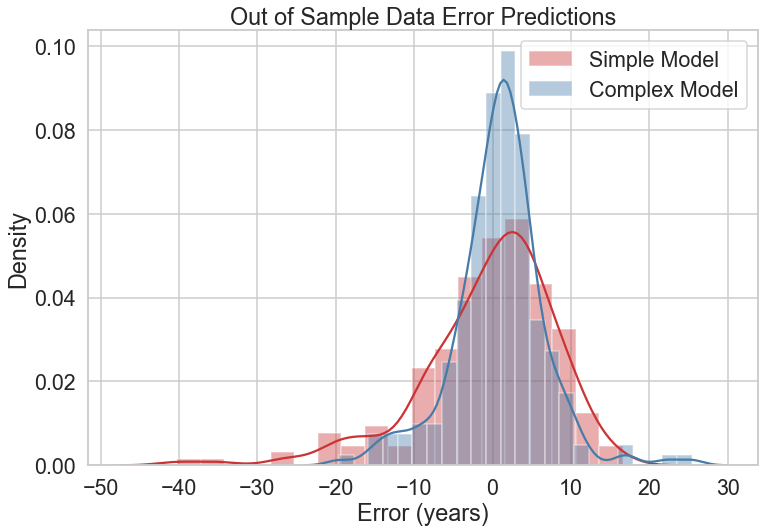

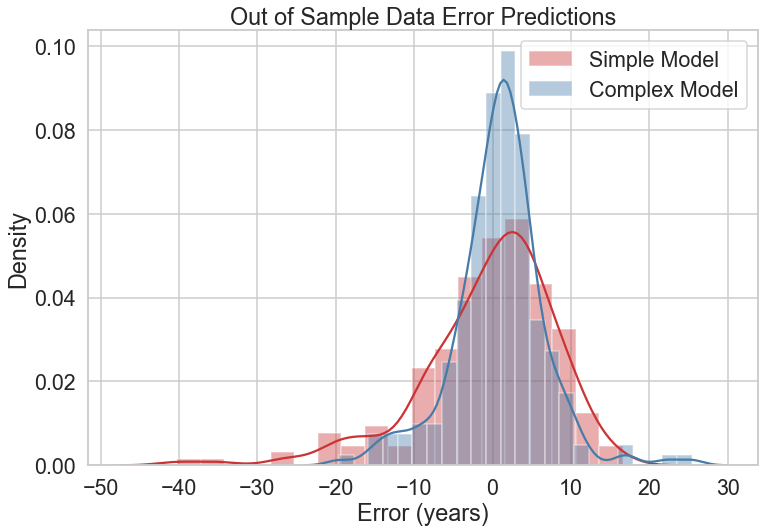

In [223]:
plot_list = {
    "Simple Model" : np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
}
plot_ae_histOne(plot_list, title='Out of Sample Data Error Predictions', set_context='talk',
            fig_tuple=(12, 8), file_title='simple_hist.png')

## Hypothesis #3

The model trained with many derived features will perform better than the model with fewer, simpler features when tested on data collected at different sites. 

### HCP Data

#### Complex Model vs Simple Model

In [192]:
def get_wil_help(df_atf, y_pred_atf, y_pred_stack, df_age, subj='Subject',):
    df = pd.DataFrame([])
    df[subj] = df_atf[subj]
    df['atf_pred'] = y_pred_atf
    df['stack'] = y_pred_stack
    df = df.merge(df_age, on = subj)
    df['Atf_Err'] = np.subtract(df.atf_pred, df.Age_in_Yrs)
    df['Complx_Err'] = np.subtract(df['stack'], df.Age_in_Yrs)
    return df

In [193]:
df_hcp_pred_data = get_wil_help(df_hcp_atf, y_predicted_hcp_atf,
                                  y_predicted_stack_hcp, df_hcp_age, subj='Subject')

In [194]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.Atf_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  29111.0 
 Pvalue:  9.848449887860512e-109 
 Correlation:  0.07260325219473264


<Figure size 432x288 with 0 Axes>

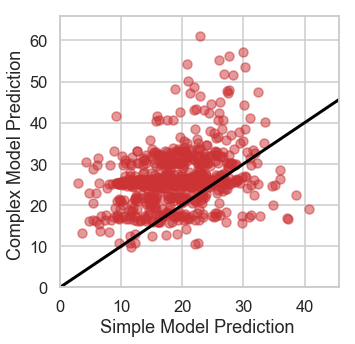

In [195]:
plot_simple_v_complex(df_hcp_pred_data.atf_pred, df_hcp_pred_data['stack'], title='', 
                      label='Simple', fig_tuple=(5, 5))

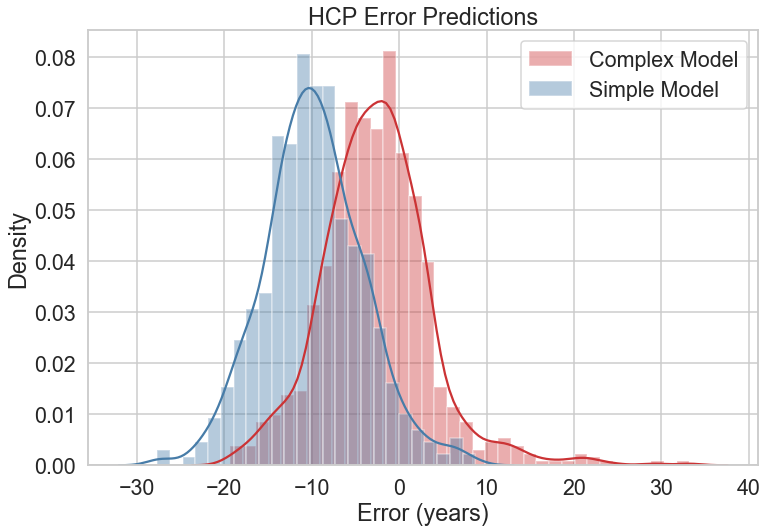

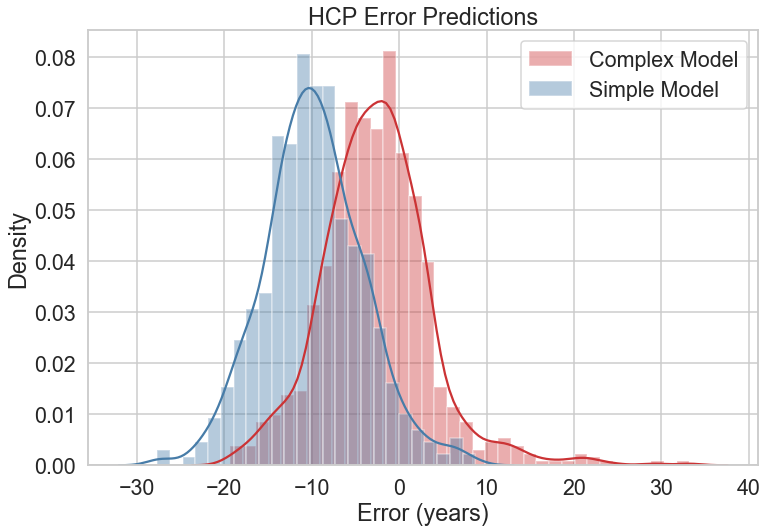

In [224]:
plot_list_hcp = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Model" : df_hcp_pred_data.Atf_Err
}
plot_ae_histOne(plot_list_hcp, title='HCP Error Predictions', set_context='talk',
            fig_tuple=(12, 8), file_title="hcp_simple_hist.png")

### NKI Data

#### Complex Model vs Simple Model

In [199]:
def get_wil_help(df_atf, y_pred_atf, y_pred_stack, df_age, subj='Subject',):
    df = pd.DataFrame([])
    df[subj] = df_atf[subj]
    df['atf_pred'] = y_pred_atf
    df['stack'] = y_pred_stack
    df = df.merge(df_age, on = subj)
    df['Atf_Err'] = np.subtract(df.atf_pred, df.age)
    df['Complx_Err'] = np.subtract(df['stack'], df.age)
    return df

In [200]:
df_nki_pred_data = get_wil_help(df_nki_atf, y_predicted_nki_atf,y_predicted_stack_nki,
                                 df_nki_ages, subj='participant_id')

In [201]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.Atf_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  135329.0 
 Pvalue:  4.924969762131745e-16 
 Correlation:  0.342851569229522


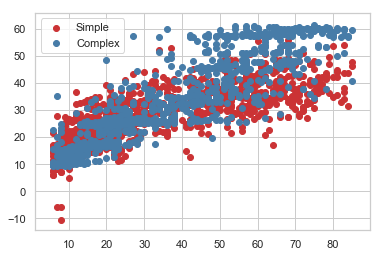

<Figure size 432x288 with 0 Axes>

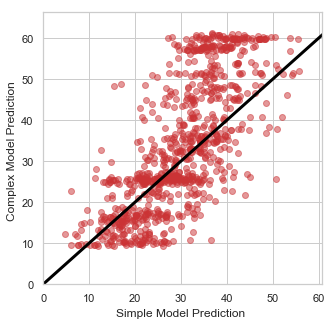

In [202]:
import seaborn as sns
sns.set_context('notebook')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data.atf_pred, label = 'Simple')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data['stack'], label ='Complex')
plt.legend(loc='best')
plt.show()
plot_simple_v_complex(df_nki_pred_data.atf_pred, df_nki_pred_data['stack'], title='',
                     fig_tuple=(5, 5), fig_title='nki_graph.png')

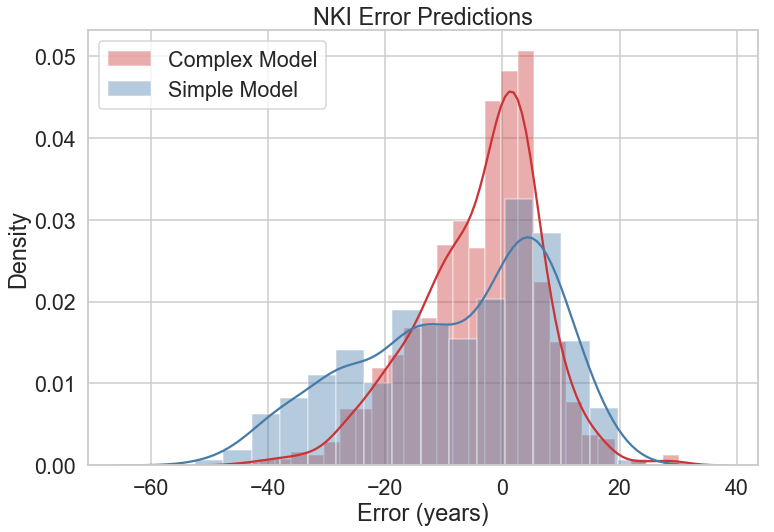

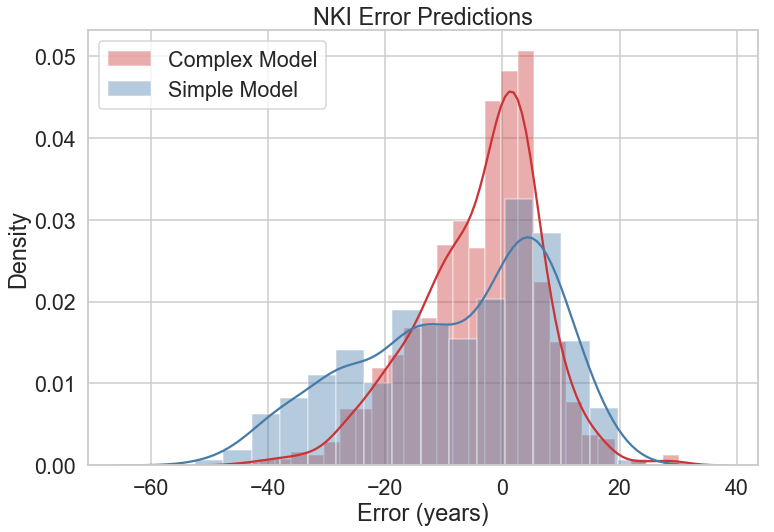

In [225]:
plot_list_nki = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Model" : df_nki_pred_data.Atf_Err
}
plot_ae_histOne(plot_list_nki, title='NKI Error Predictions', set_context='talk',
            fig_tuple=(12, 8), file_title="nki_simple_hist.png")

# Exploratory Analysis

## Train Test Split

In [199]:
df_nki_atf['random'] = [0 for x in range(0, len(df_nki_atf))]

In [200]:
df_nki_atf.columns

Index(['participant_id', 'age', 'sex', 'handedness', 'Intra_Cran_Vol',
       'WM_Frac', 'GM_Frac', 'CSF_Frac', 'random'],
      dtype='object')

In [201]:
df_nki_atf = df_nki_atf[['participant_id', 'age', 'random', 'sex', 'handedness', 'Intra_Cran_Vol',
       'WM_Frac', 'GM_Frac', 'CSF_Frac' ]]

In [202]:
df_nki_atf.head()

,participant_id,age,random,sex,handedness,Intra_Cran_Vol,WM_Frac,GM_Frac,CSF_Frac
0,A00008326,59.0,0,FEMALE,RIGHT,1.145520e+06,0.341896,0.040462,0.019131
1,A00008399,23.0,0,MALE,RIGHT,1.758887e+06,0.309256,0.038880,0.008169
2,A00010893,28.0,0,MALE,RIGHT,1.354414e+06,0.299072,0.039970,0.013772
3,A00013809,61.0,0,FEMALE,RIGHT,1.127873e+06,0.345974,0.042164,0.015808
4,A00018030,11.0,0,FEMALE,LEFT,1.445121e+06,0.312098,0.041026,0.007810


In [ ]:
test = mult_iterations(5, df_data_ct, df_data_sv, df_data_ca, df_data_hcp_ct, df_data_hcp_sv, df_data_hcp_ca, df_data_nki_ct, df_data_nki_sv, df_data_nki_ca,
                   df_atf, df_hcp_atf, df_nki_atf)

Fitting stacking model
best max_depth: 5
0
Fitting stacking model
best max_depth: 4
1
Fitting stacking model
best max_depth: 3
2
Fitting stacking model
best max_depth: 5
3
Fitting stacking model


In [186]:
test

,kpval_hcp,kpval_nki,kpval_ts,kstat_hcp,kstat_nki,kstat_ts,wpval_hcp,wpval_nki,wpval_ts,wstat_hcp,wstat_nki,wstat_ts
0,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04
1,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,3.364033e-01,3.364033e-01,3.364033e-01,3.364033e-01,3.364033e-01,3.364033e-01
2,4.335196e-01,4.335196e-01,4.335196e-01,4.335196e-01,4.335196e-01,4.335196e-01,3.481500e+04,3.481500e+04,3.481500e+04,3.481500e+04,3.481500e+04,3.481500e+04
3,2.415569e-74,2.415569e-74,2.415569e-74,2.415569e-74,2.415569e-74,2.415569e-74,9.633367e-102,9.633367e-102,9.633367e-102,9.633367e-102,9.633367e-102,9.633367e-102
4,1.396396e-01,1.396396e-01,1.396396e-01,1.396396e-01,1.396396e-01,1.396396e-01,1.264640e+05,1.264640e+05,1.264640e+05,1.264640e+05,1.264640e+05,1.264640e+05
5,4.914067e-08,4.914067e-08,4.914067e-08,4.914067e-08,4.914067e-08,4.914067e-08,1.812085e-20,1.812085e-20,1.812085e-20,1.812085e-20,1.812085e-20,1.812085e-20
6,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,1.851852e-01,9.954000e+03,9.954000e+03,9.954000e+03,9.954000e+03,9.954000e+03,9.954000e+03
7,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,1.006189e-03,5.508027e-02,5.508027e-02,5.508027e-02,5.508027e-02,5.508027e-02,5.508027e-02
8,5.351955e-01,5.351955e-01,5.351955e-01,5.351955e-01,5.351955e-01,5.351955e-01,1.302600e+04,1.302600e+04,1.302600e+04,1.302600e+04,1.302600e+04,1.302600e+04
9,4.406740e-113,4.406740e-113,4.406740e-113,4.406740e-113,4.406740e-113,4.406740e-113,1.026794e-129,1.026794e-129,1.026794e-129,1.026794e-129,1.026794e-129,1.026794e-129


In [182]:
huge_it[huge_it.kpval_ts > 0.05].head()

,kpval_hcp,kpval_nki,kpval_ts,kstat_hcp,kstat_nki,kstat_ts,wpval_hcp,wpval_nki,wpval_ts,wstat_hcp,wstat_nki,wstat_ts
0,0.212963,0.212963,0.212963,0.212963,0.212963,0.212963,8704.0,8704.0,8704.0,8704.0,8704.0,8704.0
2,0.544134,0.544134,0.544134,0.544134,0.544134,0.544134,17358.0,17358.0,17358.0,17358.0,17358.0,17358.0
4,0.206081,0.206081,0.206081,0.206081,0.206081,0.206081,63227.0,63227.0,63227.0,63227.0,63227.0,63227.0
6,0.171296,0.171296,0.171296,0.171296,0.171296,0.171296,11631.0,11631.0,11631.0,11631.0,11631.0,11631.0
8,0.486034,0.486034,0.486034,0.486034,0.486034,0.486034,24451.0,24451.0,24451.0,24451.0,24451.0,24451.0


In [183]:
#huge_it = 30000
#new_it = 1000
#df_tt_split = 400

In [159]:
df_tt_split[df_tt_split.kpval_ts> 0.05]

,stack_ts,stack_hcp,stack_nki,simple_ts,simple_hcp,simple_nki,wstat_ts,wpval_ts,wstat_hcp,wpval_hcp,wstat_nki,wpval_nki,kstat_ts,kpval_ts,kstat_hcp,kpval_hcp,kstat_nki,kpval_nki
29,4.46555,5.38558,10.1489,6.92424,10.5128,13.7173,10966,0.413498,24682,2.52922e-114,121415,2.98305e-23,0.12037,0.0808069,0.493855,2.37755e-96,0.114865,1.41934e-05
262,4.48503,5.41455,9.79162,6.99859,10.2657,13.6028,10712,0.273971,27716,1.76968e-110,104990,1.32051e-33,0.125,0.0628356,0.444693,3.33974e-78,0.15991,2.09825e-10
399,4.32889,5.43563,8.81128,6.43395,10.0855,12.784,11009,0.44071,19130,1.56472e-121,139831,5.29321e-14,0.12037,0.0808069,0.522905,5.7402e-108,0.136261,1.13551e-07


In [ ]:
sns.distplot(df_tt_split.pval_nki)
plt.show()

In [ ]:
df_tt_split[df_tt_split.pval_nki > 0.05]

In [ ]:
plt.scatter(df_tt_split.stack_ts, df_tt_split.stack_nki)
plt.scatter(df_tt_split.simple_ts, df_tt_split.simple_nki)
plt.show()